In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import pandas as pd
import numpy as np
import tensorflow as tf

# 01C-tensorflow-neural-network-regression

Contents:
* Medical Cost Prediction (Regression) - Predict the medical cost of a person given various details such as age, sex, bmi, no of children, smoker or not, region

## Data Details

Columns

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: Smoking

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance

### Load the data

In [7]:
df = pd.read_csv('../data/medical_cost/medical_cost.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### No of data points

In [10]:
df.shape

(1338, 7)

#### Summary

In [9]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


#### Data types

Data types seem fine

In [8]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

#### Missing values
* Great! No missing values.

In [11]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Distribution of the variables

* Since we have 6 independent variables to plot, we can have 2 row 3 column layout. 
* Continuous - Histogram, Categorical - Barplot

In [19]:
import matplotlib.pyplot as plt

In [17]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


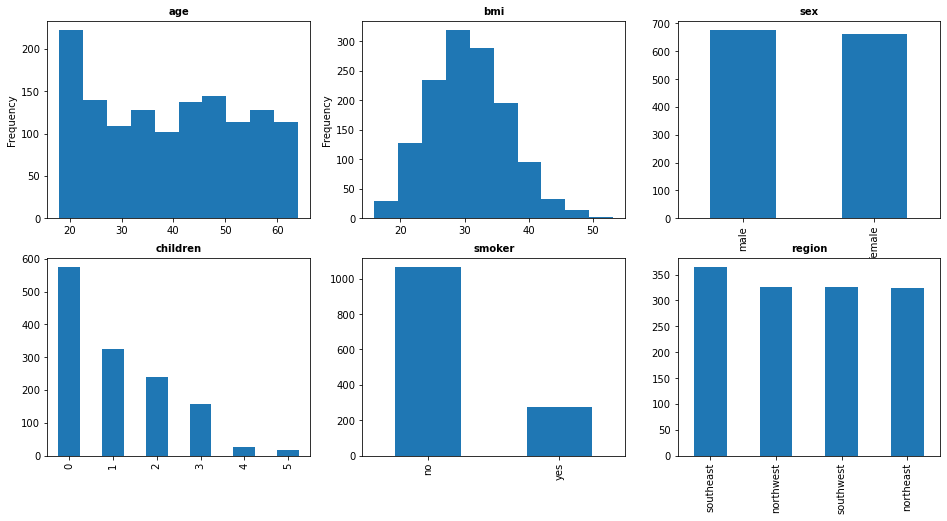

In [30]:
fig, axn = plt.subplots(2, 3, figsize=(16, 8))

columns = {'cont': ['age', 'bmi'], 
           'cat': ['sex', 'children', 'smoker', 'region']}

axn_flat = axn.flatten()

i = 0
for vartype, varlist in columns.items():
    for var in varlist:
        
        ax = axn_flat[i]
        
        if vartype == 'cont':
            df[var].plot(kind='hist', ax=ax)
        else:
            d = df[var].value_counts()
            d.plot(kind='bar', ax=ax)
            
        ax.set_title(var, fontdict=dict(weight='bold', size=10))
            
        
        i += 1
    

We could dedicate a separate notebook for EDA, but here are a few observations:

* We have a disproportionate amount of 20 year olds, but the distribution is sort of uniform over 20-60ish age range
* BMI seems symmetric and maybe even normal and centred around 30 (Depending on the scale/method this seems to be very high BMI; not sure)
* Almost equal proportion of male and female
* Mostly people don't have children, and less people with more children follows here.
* More non smokers than smokers.
* Somewhat higher from southeast region but more or less uniformly distributed otherwise.

### Distribution of Independent variable (Charges)

<AxesSubplot:ylabel='Frequency'>

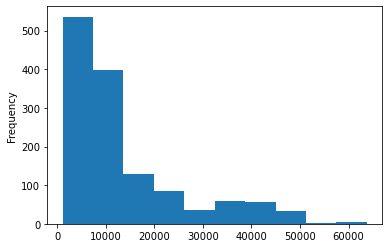

In [32]:
df['charges'].plot(kind='hist')

* Highly right skewed. We have  mostly less medical charges (i.e. in one range) and some very high deviations from that make the curve right skewed.

### Correlation (Continous + Ordinal variables)

* age, bmi, children
* charges

In [35]:
df[['age', 'bmi', 'children'] + ['charges']].corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


* Age seems to be highly correlated with charges and will likely be an important variable
* bmi also is somewhat important

#### Dependant and independant variable

In [90]:
data, labels = df.drop('charges', axis=1), df['charges']

### Train test split

In [91]:
from sklearn.model_selection import train_test_split

data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size=0.3, random_state=42)

In [92]:
data_train.shape, label_train.shape

((936, 6), (936,))

### Featurization 

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, Normalizer, MinMaxScaler)

preprocess = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['sex', 'region', 'smoker'])
], remainder='passthrough')

preprocess.fit_transform(data_train)

array([[ 1.   ,  0.   ,  0.   , ..., 61.   , 31.16 ,  0.   ],
       [ 0.   ,  1.   ,  0.   , ..., 46.   , 27.6  ,  0.   ],
       [ 1.   ,  0.   ,  0.   , ..., 54.   , 31.9  ,  3.   ],
       ...,
       [ 0.   ,  1.   ,  1.   , ..., 58.   , 25.175,  0.   ],
       [ 1.   ,  0.   ,  0.   , ..., 37.   , 47.6  ,  2.   ],
       [ 0.   ,  1.   ,  0.   , ..., 55.   , 29.9  ,  0.   ]])

### Boxcox transformation for y

In [140]:
from src import BoxCoxTransformer

<AxesSubplot:ylabel='Frequency'>

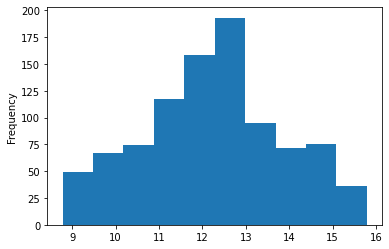

In [145]:
bctrans = BoxCoxTransformer(alpha=0.05)
label_train_boxcox = bctrans.fit_transform(label_train)
label_train_boxcox.plot(kind='hist')

In [146]:
label_test_boxcox = bctrans.transform(label_test)

### Prediction pipeline

In [151]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [55]:
pipe = Pipeline([
    ('preprocess', preprocess),
    ('scale', StandardScaler()),
    ('reg', LinearRegression())
])


# NOTE: Increasing tolerance to make Lasso converge (https://stackoverflow.com/questions/20681864/lasso-on-sklearn-does-not-converge)
param_grid = [{'reg': [LinearRegression()]},
              {'reg': [Ridge(), Lasso(tol=0.01)], 'reg__alpha': [0.01, 0.1, 1, 10, 100]}] 


GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['sex',
                                                                          'region',
                                                                          'smoker'])])),
                                       ('scale', StandardScaler()),
                                       ('reg', LinearRegression())]),
             param_grid=[{'reg': [LinearRegression()]},
                         {'reg': [Ridge(), Lasso(alpha=100, tol=0.01)],
                          'reg__alpha': [0.01, 0.1, 1, 10, 100]}],
             scoring='neg_mean_squared_error')

In [148]:
grid_search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error')
grid_search.fit(data_train, label_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['sex',
                                                                          'region',
                                                                          'smoker'])])),
                                       ('scale', StandardScaler()),
                                       ('reg', LinearRegression())]),
             param_grid=[{'reg': [LinearRegression()]},
                         {'reg': [Ridge(), Lasso(alpha=100, tol=0.01)],
                          'reg__alpha': [0.01, 0.1, 1, 10, 100]}],
             scoring='neg_mean_squared_error')

#### Best estimator and score

In [149]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'reg': Lasso(alpha=100, tol=0.01), 'reg__alpha': 100}
-38462910.83875291


#### MSE

In [152]:
y_test_pred = grid_search.predict(data_test)
mean_squared_error(label_test, y_test_pred)

33887115.1204235

### Now let us see how it performs with BoxCox transform

In [153]:
grid_search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error')
grid_search.fit(data_train, label_train_boxcox)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['sex',
                                                                          'region',
                                                                          'smoker'])])),
                                       ('scale', StandardScaler()),
                                       ('reg', LinearRegression())]),
             param_grid=[{'reg': [LinearRegression()]},
                         {'reg': [Ridge(), Lasso(alpha=100, tol=0.01)],
                          'reg__alpha': [0.01, 0.1, 1, 10, 100]}],
             scoring='neg_mean_squared_error')

#### Best estimator and score

In [154]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'reg': LinearRegression()}
-0.6187820835938935


But this isn't the true MSE which can be compared

#### MSE

In [155]:
y_test_pred = bt.inverse_transform(grid_search.predict(data_test))
mean_squared_error(label_test, y_test_pred)

190211810.8204741

## Tensorflow Deep Learning Model for Regression

In [162]:
from src.visualize import plot1d_reg_preds, plot_learning_curve

#### Featurize

In [184]:
X_train = preprocess.fit_transform(data_train)
X_test = preprocess.transform(data_test)

In [185]:
num_feats = X_train.shape[1]

#### Dict to store the models

In [204]:
tfmodels = {}

## Model 1: With no boxcox transform

In [205]:
y_train = label_train
y_test = label_test

In [206]:
# Set seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(25, activation='relu', input_shape=(num_feats, )),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
], name='insurance_model')

# Compile the model
model.compile(loss=tf.keras.losses.mse, optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=['mae'])

# Summary
model.summary()

Model: "insurance_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 25)                300       
_________________________________________________________________
dense_28 (Dense)             (None, 10)                260       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


In [207]:
# Fit the model!
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, verbose=0)
tfmodels['3layer_no_boxcox'] = model

(<Figure size 576x864 with 2 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'mae'}>], dtype=object))

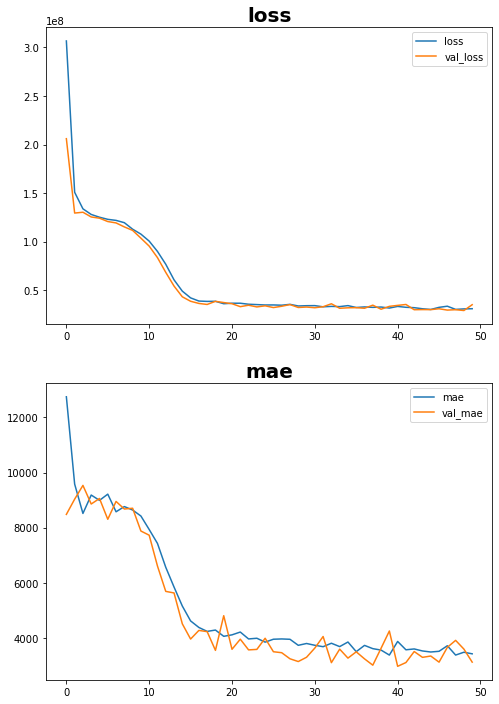

In [208]:
plot_learning_curve(history.history, extra_metric='mae')

#### Evaluate

In [209]:
y_test_pred = model.predict(X_test)
mean_squared_error(label_test, y_test_pred)

28046881.329623096

### Model 2: Same as Model 1 but label with BoxCox Transform

In [238]:
y_train = label_train_boxcox
y_test = label_test_boxcox

In [239]:
from tensorflow.keras.models import clone_model

In [240]:
# Clone the previous model
model = clone_model(tfmodels['3layer_no_boxcox'])

# Recompile the model
model.compile(loss=tf.keras.losses.mse, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['mae'])

In [241]:
# Fit the model!

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, verbose=0)
tfmodels['3layer_boxcox'] = model

(<Figure size 576x864 with 2 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'mae'}>], dtype=object))

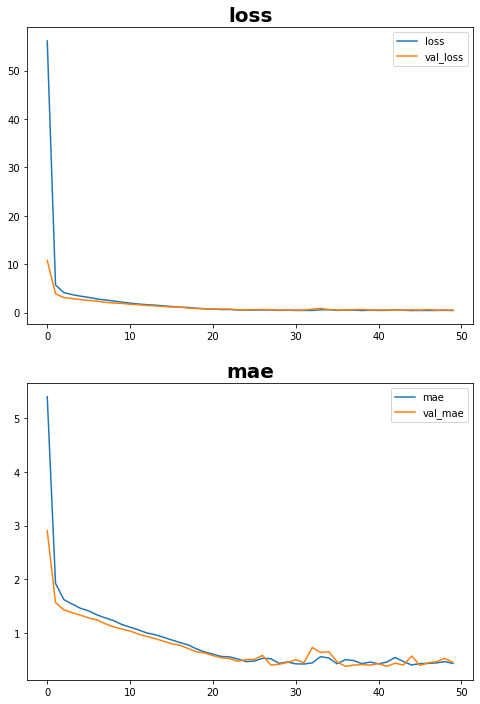

In [242]:
plot_learning_curve(history.history, extra_metric='mae')

#### Evaluate

In [243]:
y_test_pred = bt.inverse_transform(model.predict(X_test))
mean_squared_error(label_test, y_test_pred)

186991346.48781955

### Save the models!

In [244]:
for name, model in tfmodels.items():
    model.save(f'../models/medical_cost_prediction/{name}')
    model.save(f'../models/medical_cost_prediction/{name}.h5')

INFO:tensorflow:Assets written to: ../models/medical_cost_prediction/3layer_no_boxcox\assets
INFO:tensorflow:Assets written to: ../models/medical_cost_prediction/3layer_boxcox\assets
